<a href="https://colab.research.google.com/github/sadnyd/watchMe/blob/main/Models/fastaiCategorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import os
import cv2
import numpy as np


# Paths
input_folder = '/content/drive/MyDrive/watchMe/images'
output_folder = '/content/drive/MyDrive/watchMe/croppedImages'
os.makedirs(output_folder, exist_ok=True)

# Function to crop and resize images based on first non-black pixel detection
def crop_and_resize(image_path, output_size=(210, 210)):
    # Read the image
    img = cv2.imread(image_path)

    # Convert to grayscale for easier processing
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find all non-black pixels
    non_black_pixels = np.argwhere(gray > 50)  # Any pixel with a grayscale value above 10

    # If non-black pixels are found, define the bounding box
    if non_black_pixels.size > 0:
        # Get the bounding box coordinates
        top_left = non_black_pixels.min(axis=0)
        bottom_right = non_black_pixels.max(axis=0)
        x1, y1 = top_left[1], top_left[0]
        x2, y2 = bottom_right[1], bottom_right[0]

        # Crop the image based on the bounding box
        cropped_img = img[y1:y2, x1:x2]
    else:
        # If no content is found, skip this image
        return None

    # Resize the cropped image to the desired output size
    resized_img = cv2.resize(cropped_img, output_size, interpolation=cv2.INTER_AREA)

    return resized_img

# Process each image in the input folder
for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(input_folder, filename)

        # Crop and resize
        processed_img = crop_and_resize(image_path)

        # Save the image if processing was successful
        if processed_img is not None:
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, processed_img)

print("Cropping and resizing complete! Processed images are saved in 'croppedImages' folder.")


Cropping and resizing complete! Processed images are saved in 'croppedImages' folder.


In [1]:
import pathlib
import numpy as np
from fastai.vision.all import *

# Set the random seed for reproducibility
np.random.seed(42)
# Define the path to the images folder
output_folder = '/content/drive/MyDrive/watchMe/croppedImages'
images_path = pathlib.Path(output_folder)


In [2]:
def get_label(file_name):
    return file_name.name.split('-')[0]

In [3]:
# Define the path to the images folder
images_path = pathlib.Path(output_folder)

# First, let's see what files we have
image_files = get_image_files(images_path)
# Create DataLoaders with string labels
dls = ImageDataLoaders.from_path_func(
    path=images_path,
    fnames=image_files,
    label_func=get_label,
    valid_pct=0.2,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms()+ [Normalize.from_stats(*imagenet_stats)]
)

In [4]:
# Access the training and validation DataLoader directly
train_dl = dls.train
valid_dl = dls.valid

# Example of using the DataLoaders
# Iterate through batches in training DataLoader
for images, labels in train_dl:
    # Perform training step
    print(f"Batch of images: {images.shape}, Labels: {labels}")
    break  # Just show the first batch

Batch of images: torch.Size([64, 3, 224, 224]), Labels: TensorCategory([ 3,  2, 12,  2,  1,  4, 10,  5,  4,  4,  2,  6,  7,  2,  0,  4,
                10, 10, 12,  8, 11,  5, 11,  5,  4, 12,  9, 12,  9,  6, 11,  7,
                 4,  1, 10,  5, 12,  5, 10,  3, 12,  9,  2,  9,  3,  9,  8, 10,
                 8,  9,  0,  9,  7,  4,  1,  4,  6,  1,  4,  2,  2, 11,  7,  0],
               device='cuda:0')


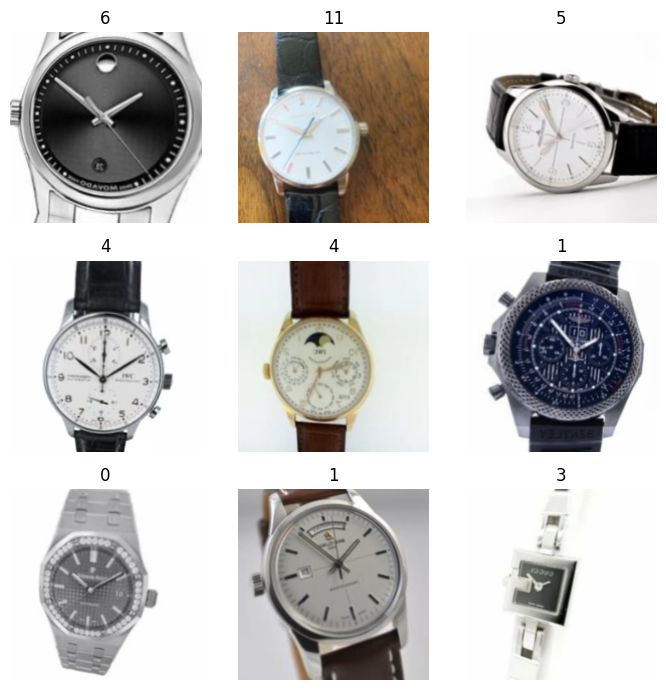

In [5]:
import matplotlib.pyplot as plt
import torch

# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get a batch of images and labels from the training DataLoader
images, labels = next(iter(dls.train))  # Get the first batch

# Move images to CPU if they are on GPU
images = images.to(device)

# Set the number of rows and columns for the plot
nrows = 3
ncols = 3  # Adjust this as needed

# Create a figure with specified size
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7, 7))

# Denormalize function for ImageNet
def denormalize(tensor):
    # Assuming ImageNet stats: mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]
    mean = torch.tensor([0.485, 0.456, 0.406]).to(tensor.device)  # Move to the same device as input tensor
    std = torch.tensor([0.229, 0.224, 0.225]).to(tensor.device)  # Move to the same device as input tensor
    denormalized = tensor * std[:, None, None] + mean[:, None, None]
    return denormalized.clamp(0, 1)  # Clamp values to [0, 1]

# Plot each image in the corresponding subplot
for i in range(nrows * ncols):
    if i < len(images):
        # Denormalize the image
        img = denormalize(images[i].cpu()).permute(1, 2, 0).numpy()  # Move to CPU before converting
        axs[i // ncols, i % ncols].imshow(img)

        # Convert the label to string and set it as the title
        axs[i // ncols, i % ncols].set_title(str(labels[i].item()))  # Use .item() to convert tensor to int
        axs[i // ncols, i % ncols].axis('off')  # Hide axis
    else:
        axs[i // ncols, i % ncols].axis('off')  # Hide unused subplots

# Adjust layout
plt.tight_layout()
plt.show()


In [6]:
# Print the unique labels found- classes
print("\nUnique labels found in the dataset:")
for index, label in enumerate(dls.vocab):
    print(f"{index}: {label}")



Unique labels found in the dataset:
0: audemarspiguet
1: breitling
2: cartier
3: gucci
4: iwc
5: jaegerlecoultre
6: movado
7: omega
8: panerai
9: patekphilippe
10: rolex
11: seiko
12: zenith


In [7]:
learner = cnn_learner(dls, models.resnet34, metrics=error_rate)

# Display the learner architecture
print(learner)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


In [8]:
learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,3.323086,1.856589,0.572165,00:33
1,2.368627,1.482309,0.447165,00:29
2,1.838830,1.323032,0.396907,00:27
3,1.508036,1.291770,0.386598,00:28
4,1.299012,1.271948,0.386598,00:29


In [9]:
interpretation=ClassificationInterpretation.from_learner(learner)

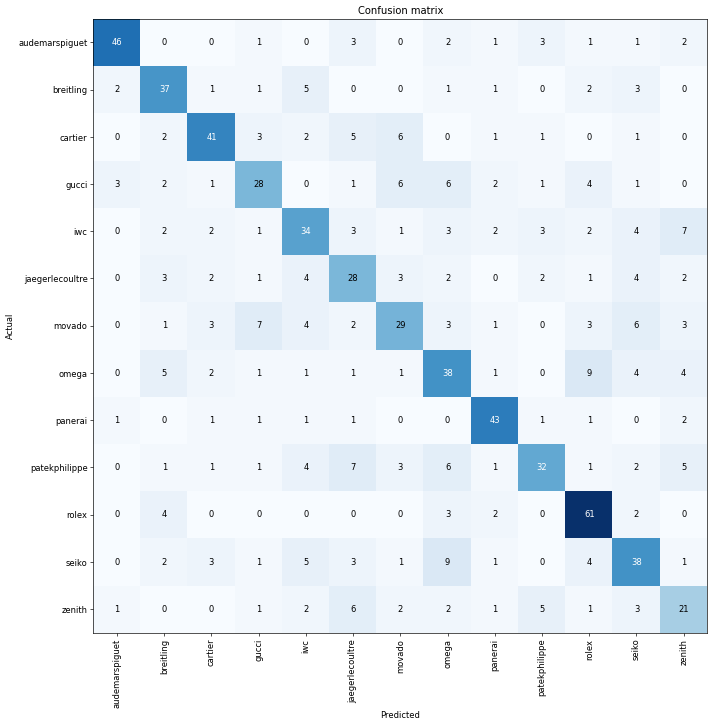

In [10]:
interpretation.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [11]:
interpretation.most_confused(min_val=2)

[('omega', 'rolex', 9),
 ('seiko', 'omega', 9),
 ('iwc', 'zenith', 7),
 ('movado', 'gucci', 7),
 ('patekphilippe', 'jaegerlecoultre', 7),
 ('cartier', 'movado', 6),
 ('gucci', 'movado', 6),
 ('gucci', 'omega', 6),
 ('movado', 'seiko', 6),
 ('patekphilippe', 'omega', 6),
 ('zenith', 'jaegerlecoultre', 6),
 ('breitling', 'iwc', 5),
 ('cartier', 'jaegerlecoultre', 5),
 ('omega', 'breitling', 5),
 ('patekphilippe', 'zenith', 5),
 ('seiko', 'iwc', 5),
 ('zenith', 'patekphilippe', 5),
 ('gucci', 'rolex', 4),
 ('iwc', 'seiko', 4),
 ('jaegerlecoultre', 'iwc', 4),
 ('jaegerlecoultre', 'seiko', 4),
 ('movado', 'iwc', 4),
 ('omega', 'seiko', 4),
 ('omega', 'zenith', 4),
 ('patekphilippe', 'iwc', 4),
 ('rolex', 'breitling', 4),
 ('seiko', 'rolex', 4),
 ('audemarspiguet', 'jaegerlecoultre', 3),
 ('audemarspiguet', 'patekphilippe', 3),
 ('breitling', 'seiko', 3),
 ('cartier', 'gucci', 3),
 ('gucci', 'audemarspiguet', 3),
 ('iwc', 'jaegerlecoultre', 3),
 ('iwc', 'omega', 3),
 ('iwc', 'patekphilippe',

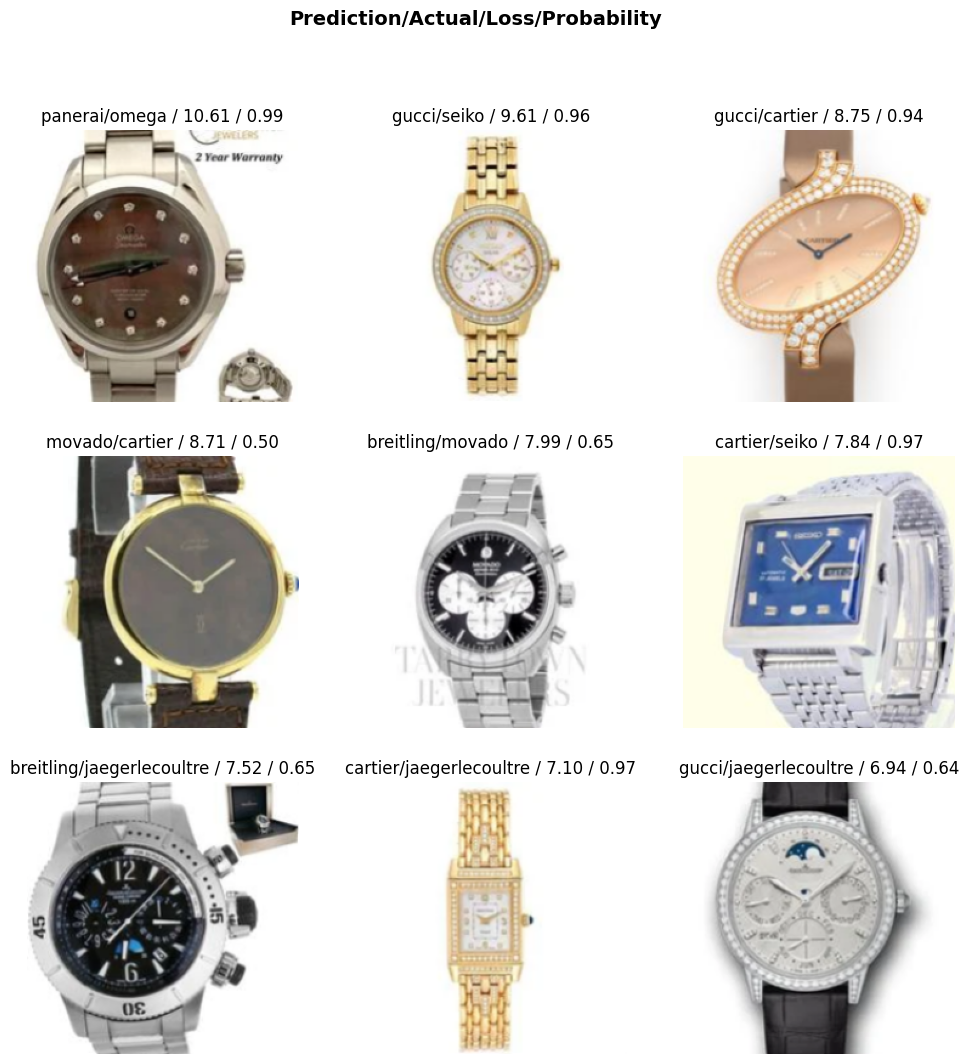

In [12]:
interpretation.plot_top_losses(9,figsize=(12,12))

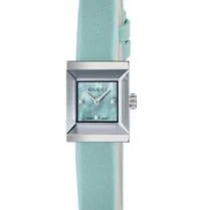

In [13]:
dls.valid_ds[100][0]

In [14]:
dls.valid_ds[100][1]

TensorCategory(3)

In [15]:
learner.predict(dls.valid_ds[100][0])

('gucci',
 tensor(3),
 tensor([2.0622e-04, 2.2557e-03, 1.5218e-02, 8.5727e-01, 2.7968e-03, 7.4762e-02,
         1.7467e-02, 5.1751e-03, 9.1705e-03, 4.9100e-03, 1.6192e-03, 3.4760e-04,
         8.8009e-03]))

In [16]:
learner.save('stage-1')

Path('/content/drive/MyDrive/watchMe/croppedImages/models/stage-1.pth')

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=0.002511886414140463)

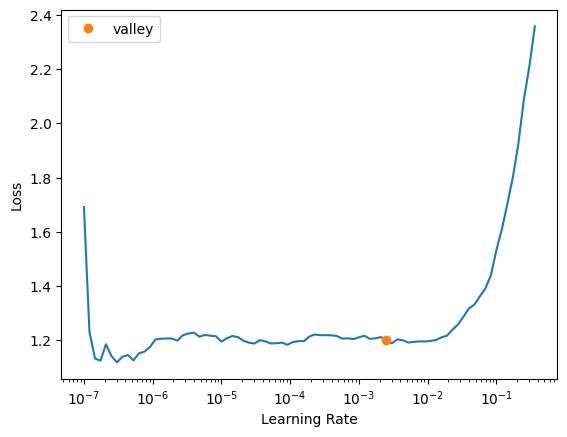

In [17]:
learner.lr_find()

In [18]:
learner.unfreeze()

In [22]:
# Fit the model using the one cycle learning rate policy
learner.fit_one_cycle(5, slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.590206,1.139638,0.300258,00:28
1,0.868664,1.516843,0.400773,00:29
2,0.796025,0.866689,0.266753,00:28
3,0.592241,0.768417,0.213918,00:29
4,0.425919,0.751456,0.210052,00:27


In [23]:
learner.save('stage-2')

Path('/content/drive/MyDrive/watchMe/croppedImages/models/stage-2.pth')

In [25]:
learner.export('fastaiClassifier.pkl')